In [2]:
import geopandas as gdf
import matplotlib.pyplot as plt
from geodatasets import get_path

def designate_stops(gdf, density_threshold):
    """
    Designate stops based on population density.
    
    Parameters:
    - gdf: GeoDataFrame containing the dataset.
    - density_threshold: Threshold for density score to qualify as a stop.
    
    Returns:
    - GeoDataFrame with an additional column 'is_stop' indicating stop designation.
    """
    # Calculate density score as population per housing unit
    gdf['density_score'] = gdf['VALUE9'] / gdf['VALUE4']
    
    # Designate stops based on density threshold
    gdf['is_stop'] = gdf['density_score'] >= density_threshold
    
    return gdf

gdf = gdf.read_file("datasets\Shapefiles\SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp")
updated_gdf = designate_stops(gdf, density_threshold=1000)  # Example threshold

# Plotting to visualize stops
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
updated_gdf.plot(column='is_stop', ax=ax, legend=True)
plt.show()


KeyboardInterrupt: 

In [17]:
from sklearn.cluster import DBSCAN
from geopandas.tools import sjoin
import numpy as np
import pandas as pd
import geopandas as gpd

def create_supergroups(gdf, eps, min_samples, population_threshold):
    """
    Create supergroups of blocks based on spatial proximity and population threshold.
    
    Parameters:
    - gdf: GeoDataFrame containing the dataset with 'geometry' and 'VALUE9' (total population).
    - eps: The maximum distance between two samples for clustering.
    - min_samples: The number of samples in a neighborhood for a point to be considered as a core point.
    - population_threshold: Minimum total population for a supergroup.
    
    Returns:
    - GeoDataFrame with an additional column 'supergroup' indicating the supergroup ID.
    """
    # Extract the coordinates of the geometries for DBSCAN
    coords = np.array(gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y)).tolist())
    
    # Apply DBSCAN clustering
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    gdf['cluster'] = db.labels_
    
    # Aggregate clusters to check if they meet the population threshold
    cluster_pop = gdf.groupby('cluster')['VALUE9'].sum().reset_index()
    under_threshold = cluster_pop[cluster_pop['VALUE9'] < population_threshold]['cluster'].tolist()
    
    # Mark clusters under the threshold for potential merging
    gdf['supergroup'] = gdf['cluster']
    for cluster in under_threshold:
        # Logic to merge clusters or redistribute blocks goes here
        # This part requires custom logic to merge or redistribute based on your specific criteria
        pass
    
    return gdf

# Usage example
eps = 0.01  # Adjust based on your spatial scale
min_samples = 5  # Minimum samples in a neighborhood to form a cluster
population_threshold = 1000 
# Assuming 'gdf' is your GeoDataFrame loaded previously
supergrouped_gdf = create_supergroups(gdf, eps, min_samples, population_threshold)


C:\Users\timtu\AppData\Local\Temp\ipykernel_4536\1426363433.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  coords = np.array(gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y)).tolist())


In [24]:
import geopandas as gpd

def find_neighbors(gdf):
    """
    For each block in the GeoDataFrame, find its immediate neighbors.
    """
    gdf['neighbors'] = None  # Initialize the column to store neighbors
    for index, block in gdf.iterrows():
        # Neighbors are those that touch the boundaries of the current block
        neighbors = gdf[gdf.geometry.touches(block['geometry'])].index.tolist()
        neighbors = [ idx for idx in neighbors if idx != index ]
        gdf.at[index, 'neighbors'] = neighbors
    return gdf

def aggregate_to_threshold(gdf, threshold):
    """
    Aggregate blocks into supergroups based on a population threshold.
    """
    grouped = []
    supergroup_id = 0
    gdf['supergroup'] = -1  # Initialize supergroup ID

    for index, block in gdf.iterrows():
        if index in grouped:
            continue  # Skip already grouped blocks

        # Start a new supergroup
        supergroup = [index]
        pop_sum = block['VALUE9']
        to_visit = block['neighbors']

        while pop_sum < threshold and to_visit:
            next_index = to_visit.pop(0)
            if next_index not in grouped:
                next_block = gdf.loc[next_index]
                pop_sum += next_block['VALUE9']
                supergroup.append(next_index)
                grouped.append(next_index)
                to_visit.extend(next_block['neighbors'])

        # Assign supergroup ID to blocks
        for idx in supergroup:
            gdf.at[idx, 'supergroup'] = supergroup_id
        supergroup_id += 1

    return gdf

# Load your GeoDataFrame 'gdf' here
gdf = gpd.read_file("datasets\Shapefiles\SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp")

# Ensure the GeoDataFrame has the 'VALUE9' column for population
gdf_with_neighbors = find_neighbors(gdf)
threshold = 2500  # Set your desired population threshold
aggregated_gdf = aggregate_to_threshold(gdf_with_neighbors, threshold)

# You can now work with 'aggregated_gdf' where blocks are grouped into supergroups
gdf_with_neighbors,aggregated_gdf

(       spatial_id                         name   VALUE0  VALUE1  VALUE2  \
 0    261635001001  BG5001001, Wayne County, MI   4.2169     NaN  0.0000   
 1    261635001002  BG5001002, Wayne County, MI   9.9465  0.0000  3.2086   
 2    261635002001  BG5002001, Wayne County, MI   0.0000  0.0000  0.0000   
 3    261635002002  BG5002002, Wayne County, MI  13.7255  9.3514  0.0000   
 4    261635003001  BG5003001, Wayne County, MI   3.7736  0.0000  0.0000   
 ..            ...                          ...      ...     ...     ...   
 620  261639852001  BG9852001, Wayne County, MI   0.0000  0.0000  0.0000   
 621  261639853001  BG9853001, Wayne County, MI   0.0000  0.0000  5.5276   
 622  261639855001  BG9855001, Wayne County, MI   0.0000  0.0000  0.0000   
 623  261639858001  BG9858001, Wayne County, MI   0.0000  0.0000  0.0000   
 624  261639859001  BG9859001, Wayne County, MI   0.0000  0.0000  0.0000   
 
       VALUE3  VALUE4  VALUE5  VALUE6  VALUE7        VALUE8  VALUE9  \
 0    96.0843  

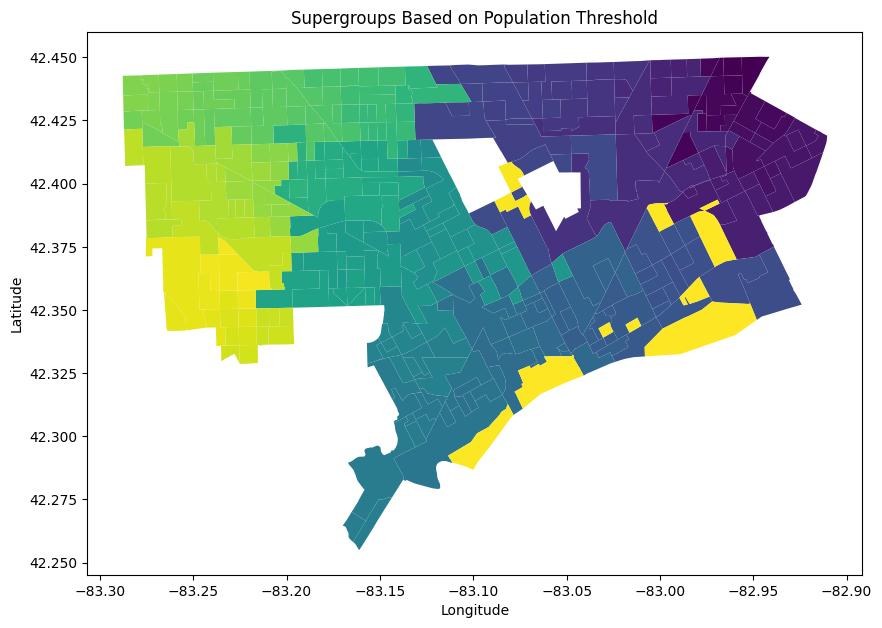

In [25]:
import matplotlib.pyplot as plt

# Assuming 'aggregated_gdf' is the GeoDataFrame after applying the aggregation logic

# We'll plot each supergroup with a different color
fig, ax = plt.subplots(figsize=(10, 10))

aggregated_gdf.dissolve(by='supergroup').plot(ax=ax, cmap='viridis')

plt.title('Supergroups Based on Population Threshold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


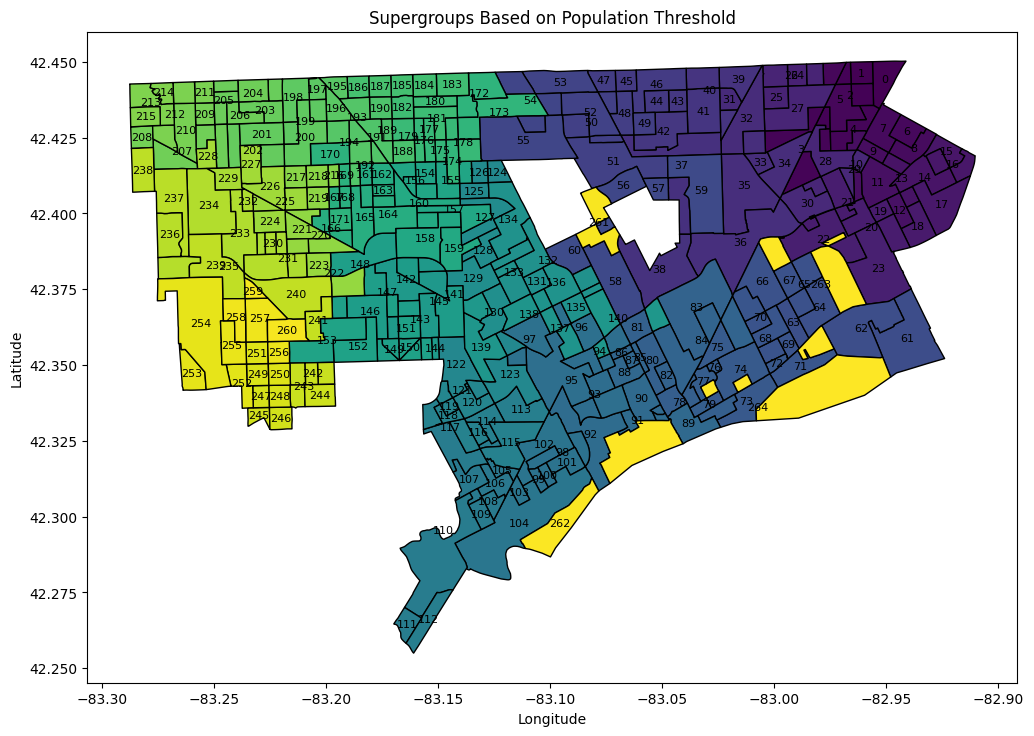

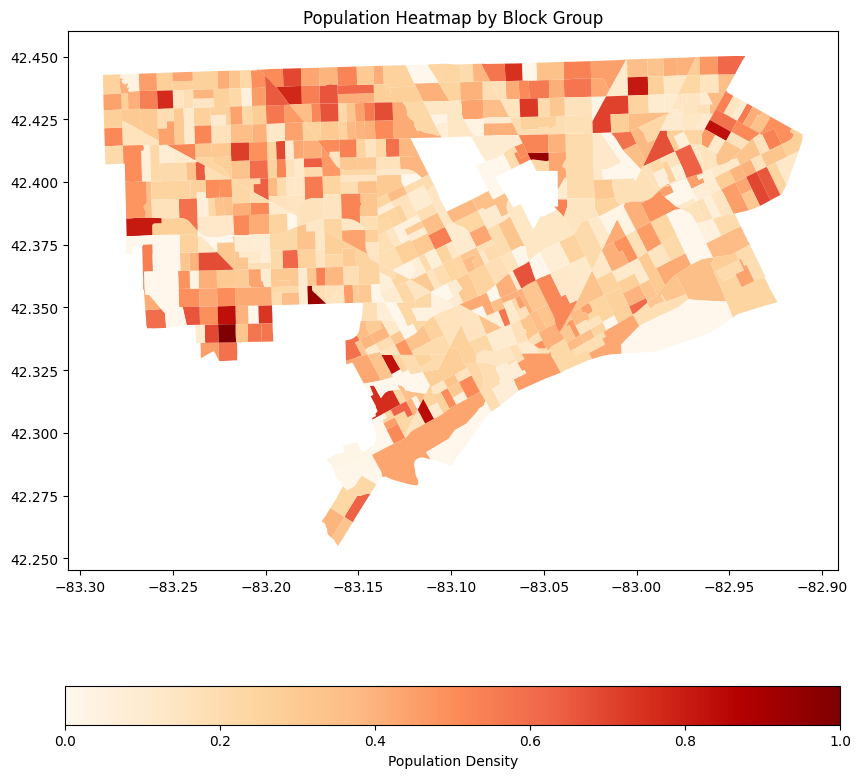

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
gdf['Population_Normalized'] = gdf['VALUE9'] / gdf['VALUE9'].max()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='Population_Normalized', ax=ax, legend=True,
         legend_kwds={'label': "Population Density", 'orientation': "horizontal"},
         cmap='OrRd')  

plt.title('Population Heatmap by Block Group')
plt.show()


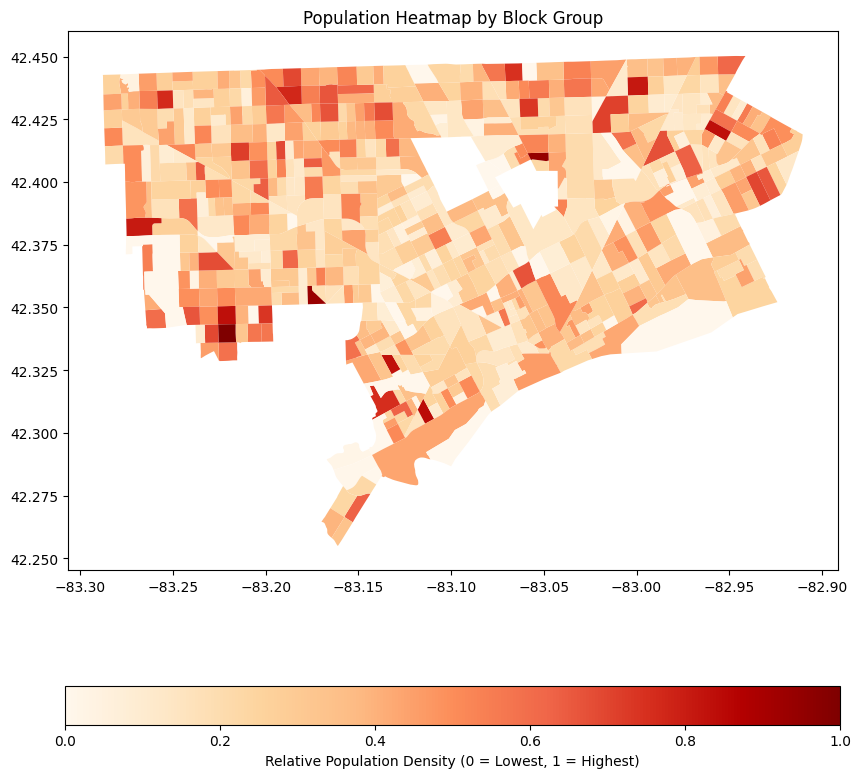

In [32]:
gdf['Population_Normalized'] = gdf['VALUE9'] / gdf['VALUE9'].max()

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
heatmap = gdf.plot(column='Population_Normalized', ax=ax, legend=True,
                   legend_kwds={'label': "Relative Population Density (0 = Lowest, 1 = Highest)",
                                'orientation': "horizontal"},
                   cmap='OrRd')  # Using 'OrRd' colormap for heatmap

plt.title('Population Heatmap by Block Group')
plt.show()

In [25]:
import geopandas as gpd
def find_adjacent_blocks(block, gdf):
    """
    Finds blocks adjacent to the given block.
    
    Parameters:
    - block: The GeoDataFrame row of the current block.
    - gdf: The entire GeoDataFrame of blocks.
    
    Returns:
    - A GeoDataFrame of adjacent blocks.
    """
    # Use the touches method to find blocks that share a boundary with the current block
    adjacent = gdf[gdf.geometry.touches(block.geometry)]
    return adjacent

def group_blocks(gdf, target_population, margin=1000):
    """
    Groups blocks into supergroups based on adjacency and population criteria.
    
    Parameters:
    - gdf: GeoDataFrame containing all blocks with their population.
    - target_population: The target population for each group.
    - margin: The margin of error for the target population.
    
    Returns:
    - A list of GeoDataFrames, each representing a grouped superblock.
    """
    grouped_blocks = []
    visited = set()
    
    for index, block in gdf.iterrows():
        if index in visited:
            continue
        
        current_group = [block]
        current_population = block['VALUE9']
        queue = [block]
        visited.add(index)
        
        while queue:
            current_block = queue.pop(0)
            if current_population >= target_population - margin and current_population <= target_population + margin:
                break
            
            adjacents = find_adjacent_blocks(current_block, gdf)
            
            for _, adj_block in adjacents.iterrows():
                adj_index = adj_block.name
                if adj_index not in visited and current_population + adj_block['VALUE9'] <= target_population + margin:
                    visited.add(adj_index)
                    current_group.append(adj_block)
                    current_population += adj_block['VALUE9']
                    queue.append(adj_block)
        
        if current_group:
            grouped_blocks.append(gpd.GeoDataFrame(current_group))
    
    return grouped_blocks



In [27]:
target_population = 20000
gdf = gpd.read_file("datasets\Shapefiles\SimplyAnalytics_Shapefiles_2024-03-25_15_51_20_06bb5972b23ee930944d21c6a8f8c132.shp")
margin = 2000
supergroups = group_blocks(gdf, target_population, margin)


C:\Users\timtu\AppData\Local\Temp\ipykernel_10236\2381643534.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(supergroups))  # Get a colormap with enough colors


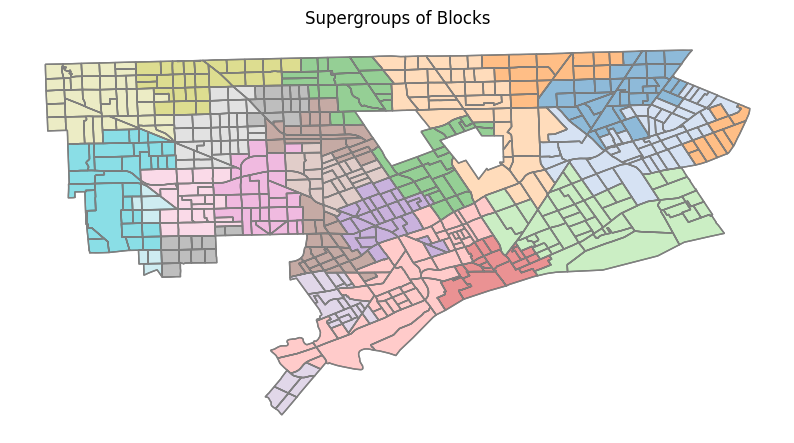

In [28]:
import matplotlib.pyplot as plt

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))
# Base map to plot the groups on, for context
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')

# Plot each group with a different color
colors = plt.cm.get_cmap('tab20', len(supergroups))  # Get a colormap with enough colors
for i, group in enumerate(supergroups):
    group.plot(ax=ax, color=colors(i), edgecolor='black', alpha=0.5)

# Optional: Customize the plot
ax.set_title('Supergroups of Blocks')
ax.set_axis_off()  # Remove axis for clarity

plt.show()


In [29]:
display(supergroups)

[      spatial_id                         name   VALUE0   VALUE1  VALUE2  \
 0   261635001001  BG5001001, Wayne County, MI   4.2169      NaN  0.0000   
 1   261635001002  BG5001002, Wayne County, MI   9.9465   0.0000  3.2086   
 3   261635002002  BG5002002, Wayne County, MI  13.7255   9.3514  0.0000   
 5   261635003002  BG5003002, Wayne County, MI   4.3478      NaN  8.6957   
 11  261635006001  BG5006001, Wayne County, MI   0.0000   0.0000  0.0000   
 18  261635007004  BG5007004, Wayne County, MI  17.5197   0.0000  0.0000   
 2   261635002001  BG5002001, Wayne County, MI   0.0000   0.0000  0.0000   
 4   261635003001  BG5003001, Wayne County, MI   3.7736   0.0000  0.0000   
 12  261635006002  BG5006002, Wayne County, MI   0.0000   0.0000  0.0000   
 13  261635006003  BG5006003, Wayne County, MI   2.7431      NaN  0.0000   
 9   261635005001  BG5005001, Wayne County, MI   2.7322   0.0000  0.0000   
 14  261635006004  BG5006004, Wayne County, MI   0.0000      NaN  0.0000   
 21  2616350

In [30]:
import folium

# Assuming `gdf` has your original geographic data and is loaded
center = gdf.geometry.centroid.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=12)
import random

for i, group in enumerate(supergroups):
    # Generate a random color for the group
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    
    # Create a GeoJson object for the group
    geojson = folium.GeoJson(
        group.geometry.to_json(),
        name=f"Group {i+1}",
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
        }
    ).add_to(m)
    
    # Optionally, add a tooltip or popup to each feature
    geojson.add_child(folium.Popup(f"Group {i+1}"))

# Add layer control to toggle groups
folium.LayerControl().add_to(m)
m


C:\Users\timtu\AppData\Local\Temp\ipykernel_10236\2186113673.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = gdf.geometry.centroid.unary_union.centroid


In [31]:
number_of_groups = len(supergroups)
print(f"Total number of groups: {number_of_groups}")


Total number of groups: 38
